In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras.optimizers as ops
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Layer, GRU
from keras.optimizers import Nadam,Adam
import keras.backend as K

In [3]:
# création de la fonction qui va traiter les données
def reg_data(df):
      # Suppression des premières lignes inutiles et d'une colonne 'MW'
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']

     # Extraction de la date en jours, mois et années
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    # Ajout de colonnes pour jours, mois et années
    df['Day'] = days
    df['Month'] = months
    df['Year'] = years

     # Fonction pour corriger les valeurs dans la colonne 'MW'
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    # Application de la fonction fixMW à la colonne 'MW' et conversion en float
    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)

    # Regroupement des données par jour, mois et année et somme des valeurs de MW
    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month')
    df['Day'] = df.index.get_level_values('Day')
    df['Year'] = df.index.get_level_values('Year')
    df.reset_index(drop=True, inplace=True)
    return df



In [4]:
# Appel de la fonction reg_data pour chaque année de données

Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17 = reg_data(Data_17)
#concatener tout les donnees dans une seule DataFrame
DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17], ignore_index=True)

In [5]:
# Affichage des données combinées avant normalisation
print("Données combinées avant normalisation :")
print(DataFrame.head())

Données combinées avant normalisation :
        MW  Month  Day  Year
0    332.0      1    1  2010
1   1898.0      2    1  2010
2   2764.0      3    1  2010
3  12736.0      4    1  2010
4   8870.0      5    1  2010


In [6]:
#copier les donnees pour les conserver et travailler seulement avec la copie
model_data = DataFrame

In [7]:
#standarization des donnees
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)
# Afficher les données normalisées
print("Données normalisées :")
print(model_data[:5])  # Affiche les 5 premières lignes des données normalisées


# Création de la fonction qui va fractionner les données en Data_train et DataTest
def split_data(df):
    train_size = int(len(df) * 0.80)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

#appel de la fonction "split data"
train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))



Données normalisées :
[[0.00118799 0.         0.         0.        ]
 [0.00741003 0.09090909 0.         0.        ]
 [0.01085082 0.18181818 0.         0.        ]
 [0.05047162 0.27272727 0.         0.        ]
 [0.03511121 0.36363636 0.         0.        ]]
2922
2337
585


577
577
2329
2329


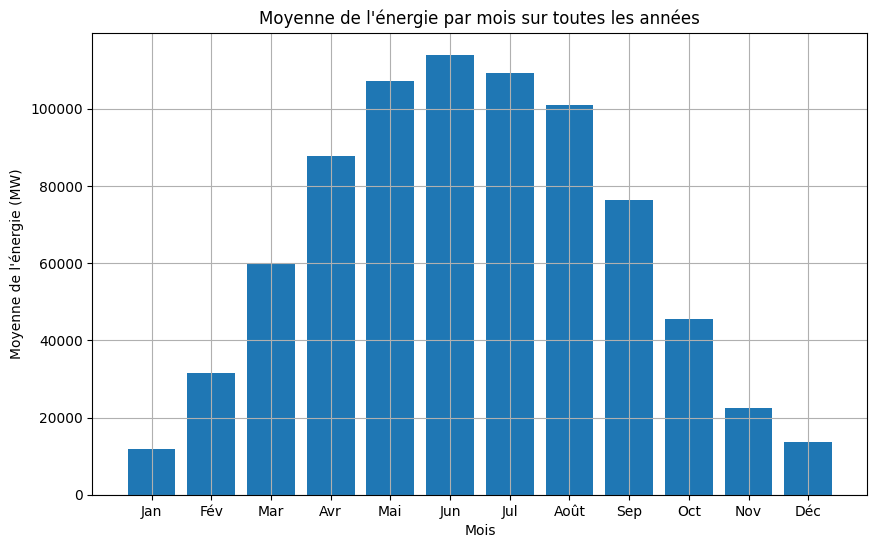

In [8]:
# Création de la fonction qui va fractionner les données Xtrain et Ytrain puis Xtest et Ytest
def Split_weekly(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Appel de la fonction Split_weekly
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)

print(len(Xtest))
print(len(Ytest))

print(len(Xtrain))
print(len(Ytrain))

# Calculer la moyenne de l'énergie pour chaque mois sur toutes les années
monthly_mean = DataFrame.groupby('Month')['MW'].mean()

# Créer un graphique à barres pour visualiser la moyenne de l'énergie par mois
plt.figure(figsize=(10, 6))
plt.bar(monthly_mean.index, monthly_mean.values)
plt.xlabel('Mois')
plt.ylabel('Moyenne de l\'énergie (MW)')
plt.title('Moyenne de l\'énergie par mois sur toutes les années')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.grid(True)
plt.show()

In [9]:
#transformer la size des donnees en 3D
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(LSTM(units = 8, input_shape=(Xtrain.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 16))
model.add(Dropout(0.2))#drop out overfetting
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = ops.Nadam(lr=1e-3), loss = 'mse')


model_train = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=8, verbose=1)

(577, 7, 1)
(2329, 7, 1)



Epoch 1/50



233/233 [==============================] - 15s 18ms/step - loss: 0.0503 - val_loss: 0.0856
Epoch 2/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0362 - val_loss: 0.0789
Epoch 3/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0341 - val_loss: 0.0820
Epoch 4/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0295 - val_loss: 0.0584
Epoch 5/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0247 - val_loss: 0.0510
Epoch 6/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0209 - val_loss: 0.0425
Epoch 7/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0197 - val_loss: 0.0520
Epoch 8/50
233/233 [==============================] - 3s 12ms/step - loss: 0.0183 - val_loss: 0.0344
Epoch 9/50
233/233 [==============================] - 3s 13ms/step - loss: 0.0173 - val_loss: 0.0325
Epoch 10/50
233/233 [==============================] - 3s 14ms/step - loss: 0.0168 - val_loss: 0.0312

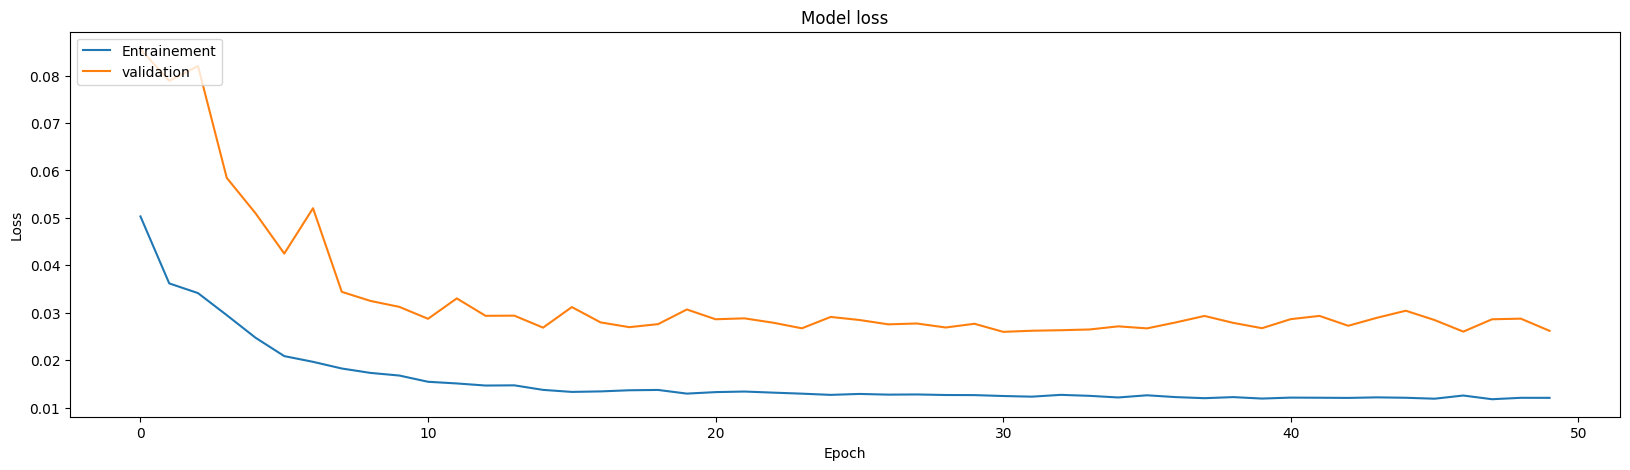

In [10]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()


ploter_Erreur(model_train)

In [11]:
train_mse_attn = model.evaluate(Xtrain, Ytrain)
test_mse_attn = model.evaluate(Xtest ,Ytest)
print("Train set MSE with attention = ", train_mse_attn)
print("Test set MSE with attention = ", test_mse_attn)




19/19 [==============================] - 0s 6ms/step - loss: 0.0344
Train set MSE with attention =  0.013853797689080238
Test set MSE with attention =  0.034419894218444824


In [12]:
# Ajout de la couche d'attention au réseau LSTM
class Attention(Layer):

    # Initialisation de la classe Attention
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
   # Construction des poids d'attention
    def build(self, input_shape):
        # Poids pour l'attention
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        # Biais pour l'attention
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)
      # Calcul de l'attention
    def call(self, x):
       # Calcul de l'énergie d'attention
        e = K.tanh(K.dot(x, self.W) + self.b)
        #Suppression de la dernière dimension
        e = K.squeeze(e, axis=-1)
        # Calcul des poids d'attention avec softmax
        alpha = K.softmax(e)
        # Extension de la dimension des poids d'attention
        alpha = K.expand_dims(alpha, axis=-1)
        # Calcul du contexte en multipliant les entrées par les poids d'attention
        context = x * alpha
        # Somme des contextes
        context = K.sum(context, axis=1)
        return context

In [13]:
    # Définition de l'entrée du modèle
    x = Input(shape=(Xtrain.shape[1], 1))
    # Première couche LSTM avec retour de séquences
    lstm_layer1 = LSTM(32, return_sequences=True)(x)
    dropout1 = Dropout(0.2)(lstm_layer1)
    # Application de la couche d'attention
    attention_layer = Attention()(dropout1)
    # Expansion de la dimension de l'attention pour la compatibilité
    attention_layer = tf.expand_dims(attention_layer, axis=1)
    # Deuxième couche LSTM sans retour de séquences
    lstm_layer2 = LSTM(32 * 2)(attention_layer)
    # Ajout de dropout pour régularisation
    dropout2 = Dropout(0.2)(lstm_layer2)
    # Couche de sortie avec activation tanh
    outputs = Dense(1, activation='tanh')(dropout2)
    # Création du modèle avec l'entrée et la sortie définies
    model2 = Model(inputs=x, outputs=outputs)
    # Compilation du modèle avec l'optimiseur Adam et la perte MSE
    model2.compile(loss='mse', optimizer=Adam(learning_rate=1e-3))
# Entraînement du modèle avec les données d'entraînement, validation_split=0.2 pour validation croisée, 150 epochs, batch_size=256, verbose=1 pour afficher les informations d'entraînement
model_train2 = model2.fit(Xtrain, Ytrain, validation_split=0.2, epochs=130, batch_size=256, verbose=1)


Epoch 1/130
8/8 [==============================] - 8s 217ms/step - loss: 0.0679 - val_loss: 0.1535
Epoch 2/130
8/8 [==============================] - 0s 25ms/step - loss: 0.0536 - val_loss: 0.1216
Epoch 3/130
8/8 [==============================] - 0s 25ms/step - loss: 0.0414 - val_loss: 0.0934
Epoch 4/130
8/8 [==============================] - 0s 29ms/step - loss: 0.0366 - val_loss: 0.0833
Epoch 5/130
8/8 [==============================] - 0s 28ms/step - loss: 0.0367 - val_loss: 0.0843
Epoch 6/130
8/8 [==============================] - 0s 28ms/step - loss: 0.0357 - val_loss: 0.0876
Epoch 7/130
8/8 [==============================] - 0s 28ms/step - loss: 0.0356 - val_loss: 0.0883
Epoch 8/130
8/8 [==============================] - 0s 29ms/step - loss: 0.0354 - val_loss: 0.0856
Epoch 9/130
8/8 [==============================] - 0s 27ms/step - loss: 0.0351 - val_loss: 0.0829
Epoch 10/130
8/8 [==============================] - 0s 26ms/step - loss: 0.0351 - val_loss: 0.0820
Epoch 11/130
8/8 [

Epoch 84/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0127 - val_loss: 0.0261
Epoch 85/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0127 - val_loss: 0.0253
Epoch 86/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0128 - val_loss: 0.0252
Epoch 87/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0126 - val_loss: 0.0267
Epoch 88/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0128 - val_loss: 0.0250
Epoch 89/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0130 - val_loss: 0.0256
Epoch 90/130
8/8 [==============================] - 0s 24ms/step - loss: 0.0126 - val_loss: 0.0258
Epoch 91/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0126 - val_loss: 0.0254
Epoch 92/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0128 - val_loss: 0.0241
Epoch 93/130
8/8 [==============================] - 0s 23ms/step - loss: 0.0131 - val_loss: 0.0276
Epoch 94/1

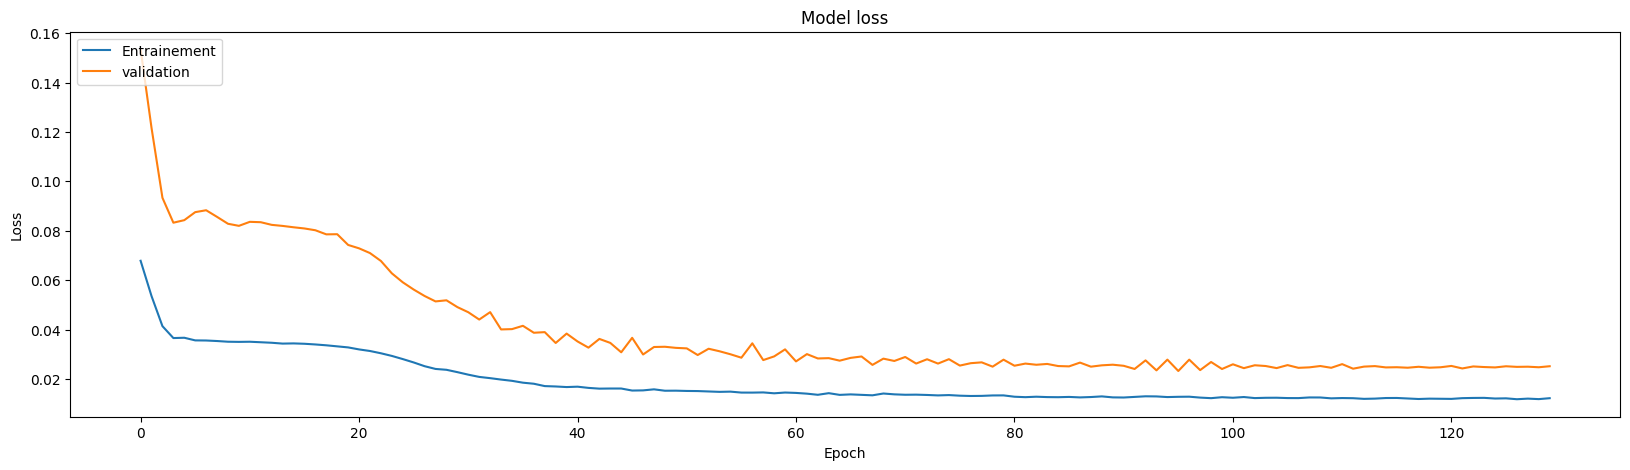

In [14]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()


ploter_Erreur(model_train2)

In [15]:
testPredict3=model2.predict(Xtest)

mean_squared_error(Ytest, testPredict3)

19/19 [==============================] - 2s 5ms/step


0.03237209292602818

In [16]:
r2 = r2_score(Ytest, testPredict3)
r2

0.5369826062152459